## Comparing Three Variations of Diffusion Maps

In [1]:
# import all functions for local transition matrix and diffusion map
import loc.loc_transition_matrix as loc_transition_matrix
import loc.loc_diffusionmap as loc_diffusionmap

# import all functions for classic transition matrix and diffusion map
import classic.T_classic as T_classic
import classic.classic_diffusionmap as classic_diffusionmap

# for loading data in correct format
import numpy as np
import csv
import pandas as pd
import random

# for analyzing row sums in section 3.2
import loc.row_sums.plot_rowsums as plot_rowsums

### 1. Introduction

Diffusion maps are a non-linear method that reduces the high dimensionality of single-cell data. They enable the analysis of cells’ differentiation trajectories and computing diffusion pseudotime. This report will consider “locally scaled” diffusion maps (Haghverdi et al., 2016).
In difference to “classic” diffusion maps (Haghverdi et al., 2015), in locally scaled diffusion maps the Gaussian kernel width is not fixed but calculated separately for each cell, using the distance between a cell and its kth nearest neighbor. This allows the locally scaled version to account for areas of different densities in the gene expression space.

To construct the diffusion map, a Gaussian wave function (1) is calculated for each cell in the data set, modelling its diffusion in the gene expression space. $\sigma_x$ is derived from cell x’s distance to its kth nearest neighbor. The interference of two cells' wave functions, given by the Gaussian kernel (2), represents the likelihood of a cell transitioning from one cell state to another. 

$$Y_x (x') = (\frac{2}{\pi \sigma_{x}^{2}})^{\frac{1}{4}} exp(-\frac{\lVert x'-x \rVert}{\sigma_{x}^{2}}) \tag{1}
$$

$$
K(x,y)=\int_{-\infty}^{\infty}Y_x (x') Y_y(x')dx' = (\frac{2\sigma_{x}\sigma_{y}}{ \sigma_{x}^{2}+\sigma_{y}^{2}})^{\frac{1}{2}} exp(-\frac{\lVert x-y \rVert^{2}}{2(\sigma_{x}^{2}+\sigma_{y}^{2})}) \tag{2}
$$

The kernel values are used to form a matrix showing the transition probabilities for each combination of cells. Some computational steps are performed to calculate the final transition probability matrix. 
First each entry is “density-normalized”. This was included in the “classic” version to account for cell environments of different densities (Haghverdi et al., 2015). Next, the matrix is row-normalized, to ensure that the probabilities in each row add to one. This produces an asymmetric transition matrix.
In interest of only having one set of eigenvectors and -values, a symmetric transition matrix was introduced (Haghverdi et al., 2016). The rows in the symmetric matrix no longer necessarily sum to one, so the difference between the row sum and one is compensated on the diagonal. 
The eigenvectors of the transition probability matrix are computed. The first is discarded, and the remaining are referred to as “diffusion components” and used to plot the diffusion map. 


### 2. Methodology

The aim of this project was to translate the existing MATLAB code ([Supplementary Software](https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.3971/MediaObjects/41592_2016_BFnmeth3971_MOESM375_ESM.zip) (Haghverdi et al., 2016)) into Python and to investigate the effect of density normalization on locally scaled diffusion maps.
Since using the nearest neighbor method when calculating sigma already takes the different densities of cell environments into consideration, it seems that density normalization may be a redundant step. To investigate its effect, multiple versions were examined with and without density normalization, listed below. The following sections explain the individual computational steps involved in calculating the different transition matrices.
1. Locally scaled symmetric, with compensation on the diagonal (2.3 and 2.4)
2. Locally scaled symmetric, without compensation on the diagonal (2.3)
3. Locally scaled asymmetric (2.2)


#### 2.1	Density normalization
The xy’th entry of the transition probability matrix is originally the value of the kernel (2) of cells x and y. In density normalization, the xy’th entry is then divided by the sum of all kernel values (3), for cell x and for cell y. This yields the provisional matrix W (4).


$$ 
Z(x) =  \sum_{y \epsilon \Omega} K(x,y) \tag{3}
$$
$$
W_{xy} = \frac{K(x,y)}{Z(x)(Z(y)} \tag{4}
$$

#### 2.2	Row normalization and asymmetric transition matrix
Each entry is divided by the sum of its row (5), to ensure that the probabilities in each row sum to one. This yields the locally scaled asymmetric transition matrix $T^{asym}$(6).


$$
\tilde{Z}(x)=\sum_{y \epsilon \Omega} W_{xy} \tag{5} $$
$$ T_{xy}^{asym}=\frac{1}{\tilde{Z}(x)}W(x,y) \tag {6}
$$

#### 2.3	Symmetric transition matrix
To obtain the symmetric transition matrix (7) instead, the sum of each row is calculated (5), and the xy’th entry is multiplied by the -0.5th power of the sum of row x and of row y. Since $\tilde{Z}(x)$ is not necessarily equal to $\tilde{Z}(y)$, this calculation does not have the same effect as the division in (6). It brings the row sums of the transition matrix close but rarely equal to one. 

$$
T_{xy}^{sym} = \tilde{Z}(x)^{-\frac{1}{2}} W_{xy} \tilde{Z}(y)^{-\frac{1}{2}} \tag{7}
$$

#### 2.4	Compensation on the diagonal
In interest of realistic probability values, the rows should sum to one. To achieve this in a symmetric transition matrix, the difference between the row sum and one is calculated and compensated on the diagonal.

#### 2.5	Data
Each of the three previously mentioned versions was run using both simulated toy data and adrenal medulla single-cell data. The simulated data consists of 1021 cells and 6 genes. The adrenal medulla data consists of 10107 cells and 2000 genes (Jansky et al., 2021).
A large number of cells was also added close to a cell in the simulated data to increase the density in its environment. The response of the different versions to this change in density was then analyzed.


### 3. Results and Discussion

#### 3.1	Simulated toy data
All versions use the first two diffusion components and local sigma is derived from the distance to the 20th nearest neighbor. 

In [2]:
# load simulated toy data:
with open('toydata.csv', 'r') as f:
    reader = csv.reader(f)
    toydata = np.array(list(reader), dtype=float)

Runtime: 
1.6845948696136475


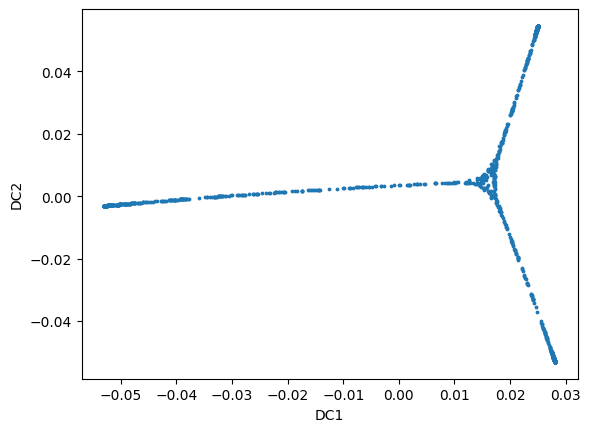

In [3]:
# 1(a) locally scaled symmetric transition matrix with density normalization, with compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata, k = 20, sym = True, density = True, diag = True)

Runtime: 
0.7235920429229736


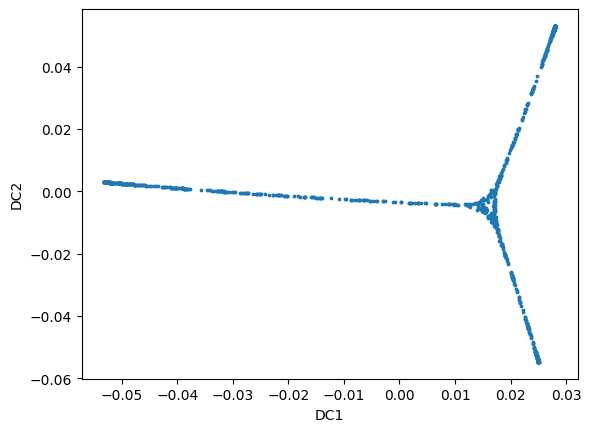

In [4]:
# 1(b) locally scaled symmetric transition matrix without density normalization, with compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata, k = 20, sym = True, diag = True)

Runtime: 
1.053950309753418


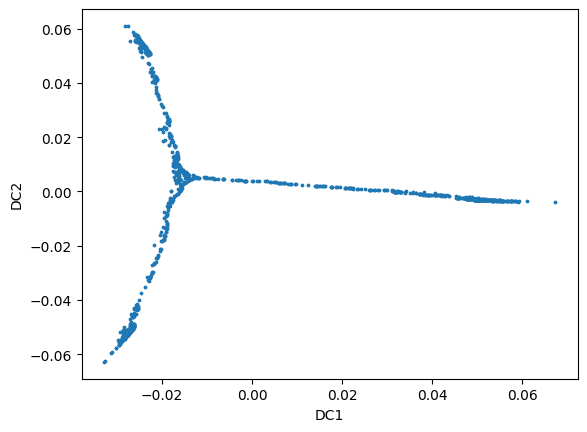

In [5]:
# 2(a) locally scaled symmetric transition matrix with density normalization, without compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata, k = 20, sym = True, density = True)

Runtime: 
0.4679872989654541


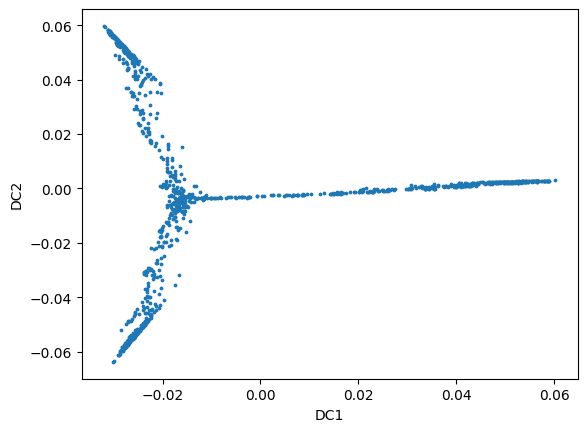

In [6]:
# 2(b) locally scaled symmetric transition matrix without density normalization, without compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata, k = 20, sym = True)

Runtime: 
0.29099488258361816


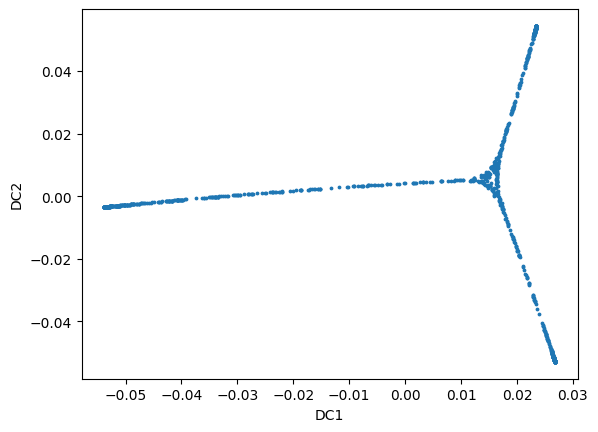

In [7]:
# 3(a) locally scaled asymmetric transition matrix with density normalization
loc_diffusionmap.loc_diffusionmap(toydata, k = 20, density = True)

Runtime: 
0.1860806941986084


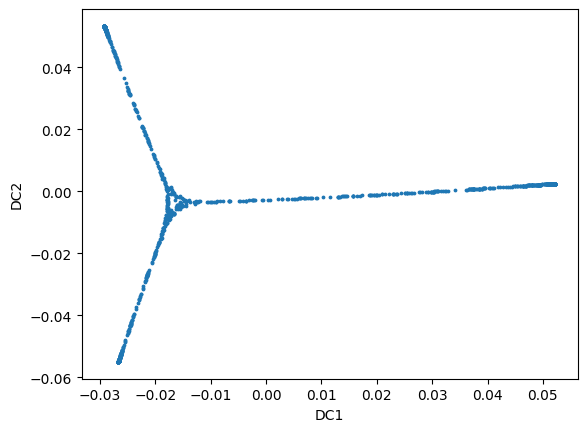

In [8]:
# 3(b) locally scaled asymmetric transition matrix without density normalization
loc_diffusionmap.loc_diffusionmap(toydata, k = 20)

The results from all versions show that omitting density normalization decreases runtime. For the symmetric version with compensation on the diagonal and the asymmetric version, omitting density normalization did not have a noticeable effect on the shape or location of the diffusion map.
Without compensation on the diagonal, the diffusion maps look very different from the other versions. The structure of the branches is less clear, especially when density normalization is omitted. 


#### 3.2	Adrenal medulla single-cell data
Since this data set is considerably larger, k was set to 50 in all versions.


In [9]:
# load adrenal medulla single-cell data:
realdata = pd.read_csv('adrenal_medulla_subset_processed.csv')
realdata = realdata.drop(realdata.columns[0], axis = 1)
realdata = realdata.transpose()
realdata = realdata.to_numpy()

In [ ]:
# the findings in this report are based on the entire data set of 10,000 cells
# for reproducibility, select random sample of 3000 cells from 10,000
random.seed(1)
realdata = np.array(random.sample(realdata.tolist(), k=3000))

Runtime: 
1948.6702008247375


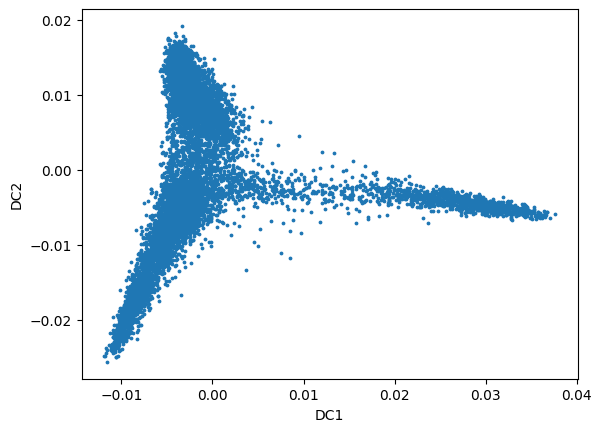

In [10]:
# 1(a) locally scaled symmetric transition matrix with density normalization, with compensation on diagonal
loc_diffusionmap.loc_diffusionmap(realdata, k = 50, sym = True, density = True, diag = True)

Runtime: 
1075.6387150287628


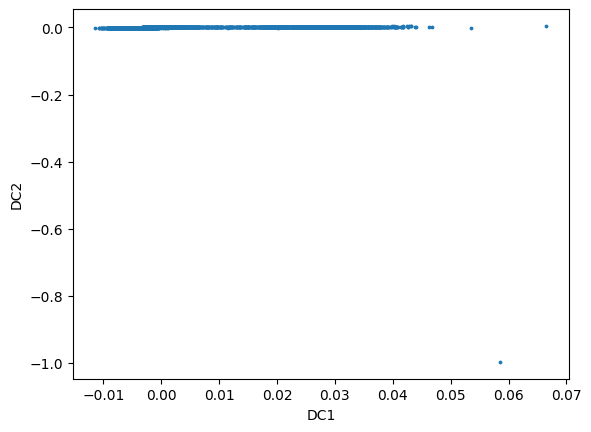

In [13]:
# 1(b) locally scaled symmetric transition matrix without density normalization, with compensation on diagonal
loc_diffusionmap.loc_diffusionmap(realdata, k = 50, sym = True, diag = True)

Runtime: 
921.8391029834747


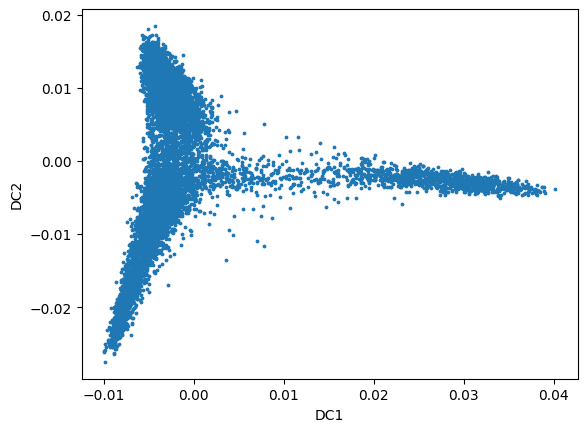

In [14]:
# 2(a) locally scaled symmetric transition matrix with density normalization, without compensation on diagonal
loc_diffusionmap.loc_diffusionmap(realdata, k =50, sym = True, density = True)

Runtime: 
462.93641209602356


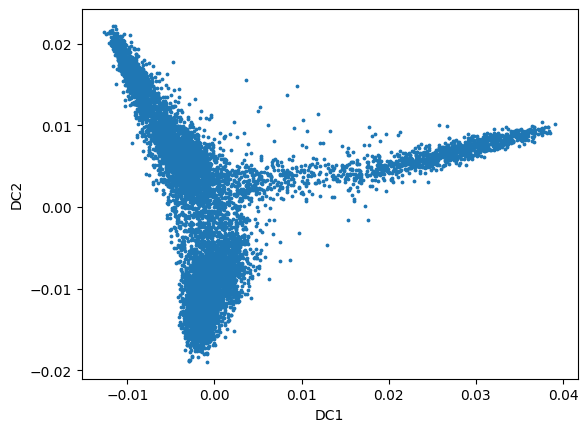

In [15]:
# 2(b) locally scaled symmetric transition matrix without density normalization, without compensation on diagonal
loc_diffusionmap.loc_diffusionmap(realdata, k = 50, sym = True)

Runtime: 
215.91191983222961


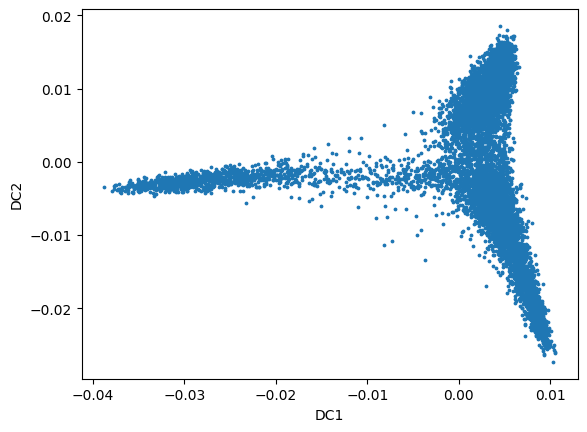

In [16]:
# 3(a) locally scaled asymmetric transition matrix with density normalization
loc_diffusionmap.loc_diffusionmap(realdata, k = 50, density = True)

Runtime: 
107.33181500434875


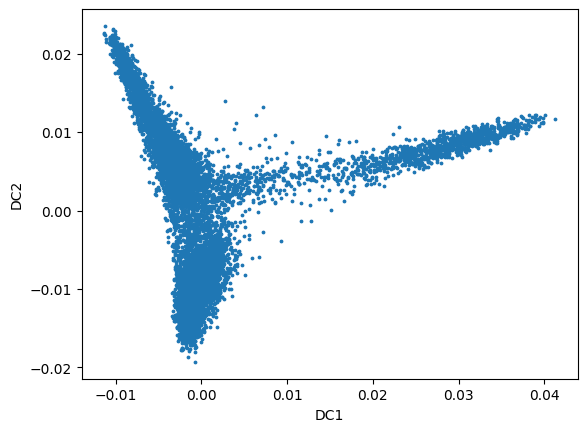

In [17]:
# 3(b) locally scaled asymmetric transition matrix without density normalization
loc_diffusionmap.loc_diffusionmap(realdata, k = 50)

The diffusion maps for adrenal medulla single-cell data had less structure than those for the simulated data. However, three clear branches can still be identified in most maps. \
Omitting density normalization in the first version using the entire set of data (10,000 cells) resulted in a graph consisting of individual points, rather than a typical diffusion map (1(b)). Here, values on the diagonal of the transition matrix had a significantly larger magnitude than other values in each row, overshadowing the probabilities to transition to other cell states. Leaving out the compensation on the diagonal avoids this problem (2(b)). Thus the problem is likely caused by shifting a notable weight onto the diagonal, meaning that the row sums in the symmetric transition matrix are previously not very close to one. In fact, while they ranged between 0.98 and 1.06 for the density normalized transition matrix, they ranged from 0.7-1.2 without density normalization (Plots 1 and 2 below). This could be caused by the larger range of row sums before row-normalization. While these ranged from 0.0028-0.0035 with density normalization, they ranged from 150-500 without it (Plots 3 and 4 below). Therefore dividing by the square roots of both row sums has a very different effect from dividing by just one row sum, as in the asymmetric version, and row-normalization is not effective in bringing the row sums very close to one. This problem can be avoided entirely in the asymmetric version, as here row normalization will always set each row sum to one, regardless of how large the range of row sums is and of whether density normalization is performed before.\
The runtime was again significantly shorter without density normalization, and much shorter for the asymmetric matrix than for the symmetric matrices.


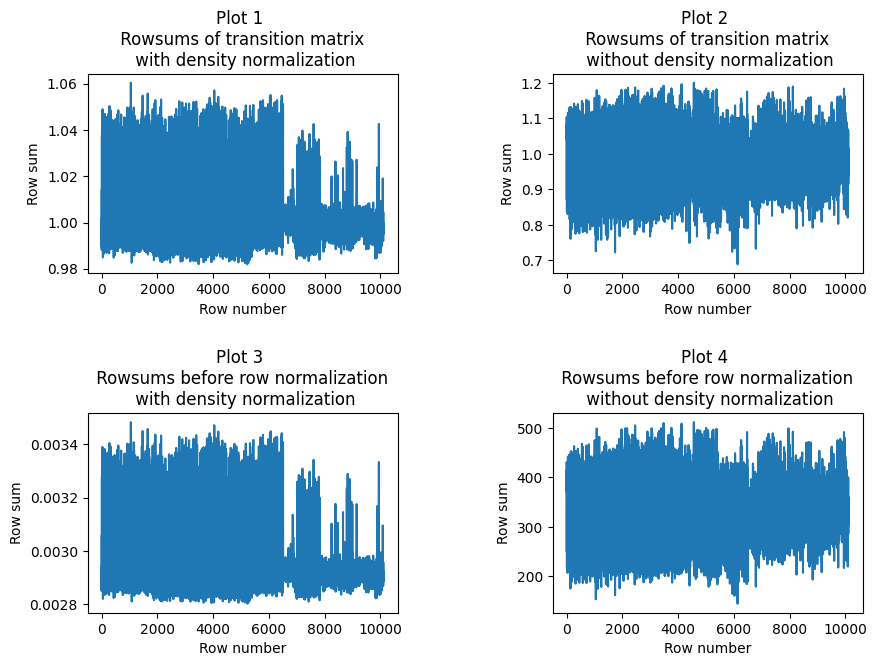

In [18]:
plot_rowsums.plot_rowsums(realdata,50)

#### 3.3	Reaction to increasing density around a cell in simulated data
To analyze the effect of increasing density around a cell, 325 cells were added with values close to cell 361, located at the end of the longest branch around (0.026,0), or (-0.026,0) in the latter versions.


In [19]:
# load simulated toy data with increased density:
with open('toydata_increased_density.csv', 'r') as f:
    reader = csv.reader(f)
    toydata2 = np.array(list(reader), dtype=float)

Runtime: 
1.2391119003295898


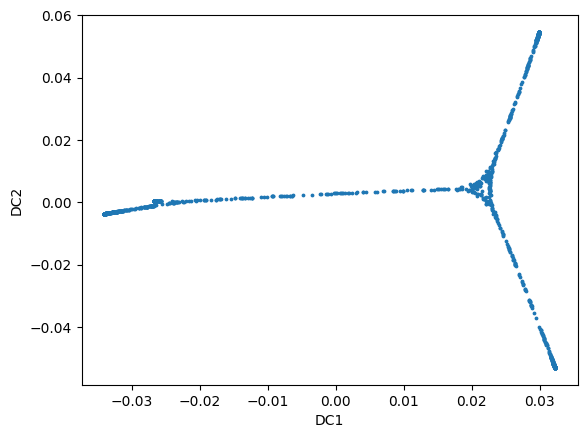

In [20]:
# 1(a) locally scaled symmetric transition matrix with density normalization, with compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata2, k = 20, sym = True, density = False, diag = True)

Runtime: 
1.146772861480713


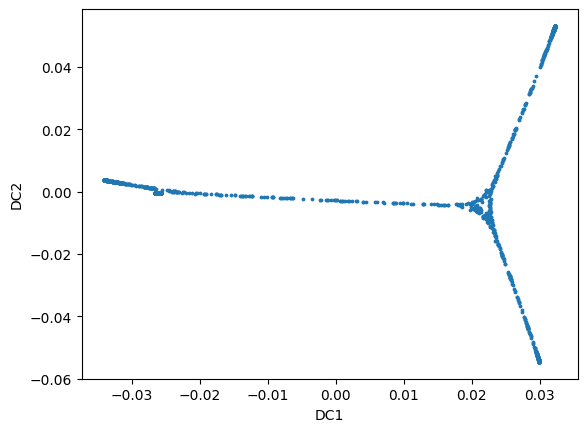

In [21]:
# 1(b) locally scaled symmetric transition matrix without density normalization, with compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata2, k = 20, sym = True, diag = True)

Runtime: 
1.2575879096984863


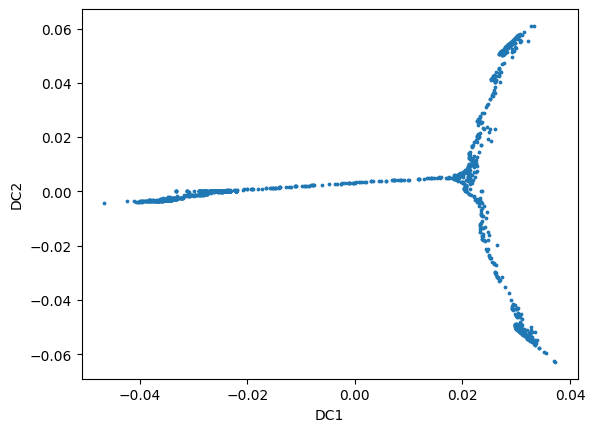

In [22]:
# 2(a) locally scaled symmetric transition matrix with density normalization, without compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata2, k = 20, sym = True, density = True)

Runtime: 
0.7655489444732666


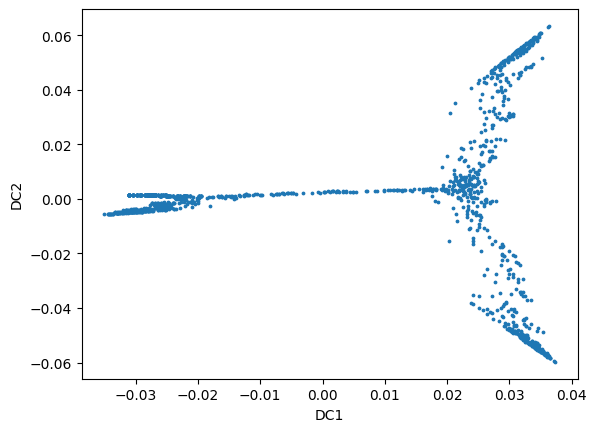

In [23]:
# 2(b) locally scaled symmetric transition matrix without density normalization, without compensation on diagonal
loc_diffusionmap.loc_diffusionmap(toydata2, k = 20, sym = True)

Runtime: 
0.41945600509643555


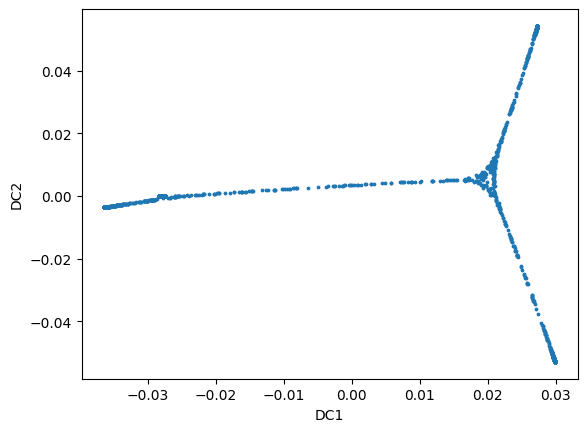

In [24]:
# 3(a) locally scaled asymmetric transition matrix with density normalization
loc_diffusionmap.loc_diffusionmap(toydata2, k = 20, density = True)

Runtime: 
0.3044619560241699


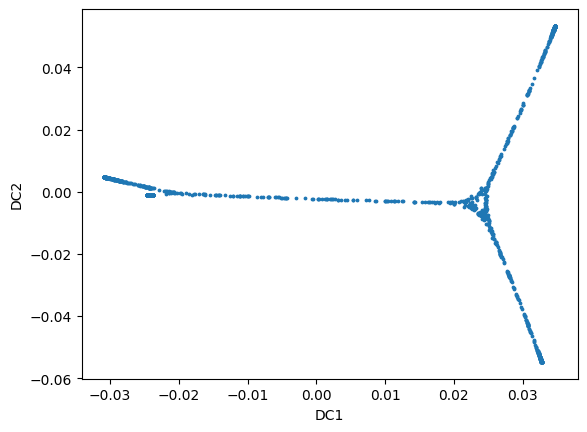

In [25]:
# 3(b) locally scaled asymmetric transition matrix without density normalization
loc_diffusionmap.loc_diffusionmap(toydata2, k = 20)

In all three versions, omitting density normalization seems to make the program more sensitive to this increased density. In 1(b), the small cluster becomes larger without density normalization. In 2(b), the cluster looks more like a subbranch when density normalization is omitted. In 3(b), the small cluster becomes larger and more detached, also indicating the beginning of a small subbranch.

#### 3.4	Classic version

Runtime: 
321.77565598487854


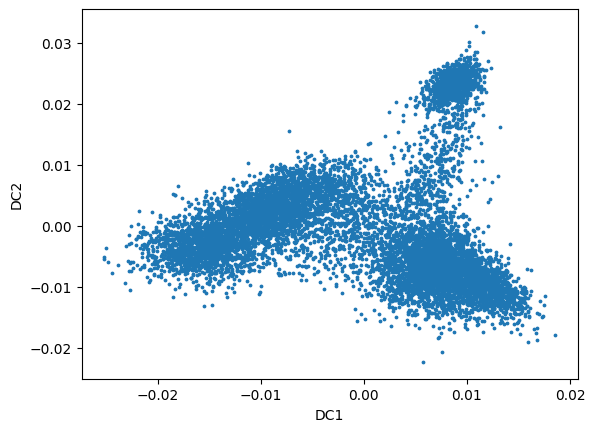

In [26]:
# load real data in section 3.2 first
classic_diffusionmap.classic_diffusionmap(realdata, sigma = 200)

Above is the diffusion map for the adrenal medulla data, produced by the classic, not locally scaled version. In this version density normalization is always included to account for different cell densities. 
Compared to the maps produced by the locally scaled versions, with and without density normalization, this map is much less clearly structured, and it is harder to identify branches. 

### 4. Conclusion

Omitting density normalization makes the locally scaled diffusion maps more sensitive to larger differences in density. However, computational issues are faced when using the symmetric transition matrix without density normalization. The row sums vary more widely, making symmetric row normalization less effective. When weight is compensated on the diagonal (self transition) this results in an overshadowing of transition probabilities to other cells. To avoid these issues, one could omit the compensation on the diagonal. In this case, the transition probabilities matrix is still positive definite (i.e., guaranteed to have real eigenvalues). However, the transition probabilities for each cell would not sum to one, making unrealistic transitions. As a result, as shown on the simulated data, the diffusion maps produced by this version can be less clearly structured. \
Instead, if one wants to omit density normalization, it is best to use the asymmetric version. It avoids the computational issues faced by symmetric versions, as probabilities for each cell already sum to one. Thus, there is no need for compensation on the diagonal or any other alteration of the results to get realistic probabilities. The final transition matrix is therefore a more direct reflection of the data. Additionally, this version has the shortest runtime. As shown in section 3.3, without density normalization, this version (3(b)) is more sensitive to changes in density than the symmetric version (1(b)). \
Since the matrix is asymmetric, the probability for cell state X to transition to cell state Y is no longer equal to the probability of cell state Y to transition to cell state X. As a result of this asymmetry, left and right eigenvectors are no longer the same. As such, the right eigenvectors (of the row normalised transition matrix) should be used for diffusion maps plotting. \
In conclusion, we recommend using the **locally scaled asymmetric diffusion maps without density normalization** for gene expression data where space metrics and density definition are only vaguely comprehensible (in contrast to e.g. 3D spatial space). The maps will be sensitive to density variations, however less sensitive than the classic version with fixed kernel width, allowing for a clearer structure. One can explore in future work if choosing the cell specific kernel width (in this work chosen as the distance to the 20th and 50th nn respectively) in alternative ways could treat density variations in a more interpretable manner.

### 5. References

* Haghverdi, L., Büttner, M., Wolf, F. A., Buettner, F., & Theis, F. J. (2016). Diffusion pseudotime robustly reconstructs lineage branching. Nature Methods, 13(10), 845-848. https://doi.org/10.1038/nmeth.3971
* Haghverdi, L., Buettner, F., & Theis, F. J. (2015). Diffusion maps for high-dimensional single-cell analysis of differentiation data. Bioinformatics, 31(18), 2989-2998. https://doi.org/10.1093/bioinformatics/btv325
* Jansky, S., Sharma, A. K., Körber, V., Quintero, A., Toprak, U. H., Wecht, E. M., Gartlgruber, M., Greco, A., Chomsky, E., Grünewald, T. G., Henrich, K., Tanay, A., Herrmann, C., Höfer, T., & Westermann, F. (2021). Single-cell transcriptomic analyses provide insights into the developmental origins of neuroblastoma. Nature Genetics, 53(5), 683-693. https://doi.org/10.1038/s41588-021-00806-1